In [1]:
import os
from glob import glob
from copy import deepcopy
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import signal

import obspy
from obspy.core import UTCDateTime
from obspy.signal.filter import envelope
from obspy.signal.invsim import paz_to_freq_resp

import changefinder

from configure import *

# Setteings
warnings.simplefilter('ignore')
plt.rcParams['figure.figsize'] = (24, 4)

# クラス・メソッドの定義

In [86]:
class MQ_Analysis:
    '''
    月震の解析用クラス
    
    Attributes:
        station (Int): ステーション番号
        lpx (Stream): LP-X DATA
        lpy (Stream): LP-Y DATA
        lpz (Stream): LP-Z DATA
        spz (Stream): SP-Z DATA
        lpx_du (Stream): LP-X DU DATA
        lpy_du (Stream): LP-Y DU DATA
        lpz_du (Stream): LP-Z DU DATA
        spz_du (Stream): SP-Z DU DATA
    '''
    def __init__(self, station):
        '''
        Initialization
        
        Args:
            input_station: ステーション番号
        '''
        self.station = station
        self.lpx = None
        self.lpy = None
        self.lpz = None
        self.spz = None
        self.lpx_du = None
        self.lpy_du = None
        self.lpz_du = None
        self.spz_du = None


    def init_data(self):
        '''
        Convert main data to DU data
        '''
        self.lpx = deepcopy(self.lpx_du)
        self.lpy = deepcopy(self.lpy_du)
        self.lpz = deepcopy(self.lpz_du)
        self.spz = deepcopy(self.spz_du)
        
        
    def read_raw(self, path):
        '''
        データのダウンロード (obspyプラグインが必要)
        
        Args:
            path (Str): RAWファイルのパスまたはダウンロードURL
                        (例: http://darts.isas.jaxa.jp/pub/apollo/pse/p14s/pse.a14.1.71)
        '''
        # ダウンロード
        data = obspy.read(path)
        
        # メンバ変数に格納 (selectが空集合の場合はNoneが入る)
        self.lpx = data.select(id='XA.S{}..LPX'.format(self.station))
        self.lpy = data.select(id='XA.S{}..LPY'.format(self.station))
        self.lpz = data.select(id='XA.S{}..LPZ'.format(self.station))
        self.spz = data.select(id='XA.S{}..SPZ'.format(self.station))
        
        # 複数データがあるものをmergeする
        if self.lpx != None: self.lpx.merge(method=1, fill_value='interpolate')
        if self.lpy != None: self.lpy.merge(method=1, fill_value='interpolate')
        if self.lpz != None: self.lpz.merge(method=1, fill_value='interpolate')
        if self.spz != None: self.spz.merge(method=1, fill_value='interpolate')

        # DU値を保存
        self.lpx_du = deepcopy(self.lpx)
        self.lpy_du = deepcopy(self.lpy)
        self.lpz_du = deepcopy(self.lpz)
        self.spz_du = deepcopy(self.spz)
        
        
    def read_sac(self, path, verbose=0):
        '''
        SACファイルを読み込む
        
        Args:
            path (Str): SACファイルが入ったディレクトリのパス
        '''
        files = glob(path + '/*.sac')
        if verbose >= 1:
            print(files)

        # メンバ変数に格納
        for file in files:
            if 'LPX.sac' in file: self.lpx = obspy.read(file)
            if 'LPY.sac' in file: self.lpy = obspy.read(file)
            if 'LPZ.sac' in file: self.lpz = obspy.read(file)
            if 'SPZ.sac' in file: self.spz = obspy.read(file)

        # DU値を保存
        self.lpx_du = deepcopy(self.lpx)
        self.lpy_du = deepcopy(self.lpy)
        self.lpz_du = deepcopy(self.lpz)
        self.spz_du = deepcopy(self.spz)

    
    
    def to_sac(self, path):
        '''
        SACファイルに出力
        
        Args:
            path (Str): SACファイルの出力先のパス (例: ./dataset/710417)
        '''
        # ステーション番号のディレクトリを作成
        dir_path = path + '/S' + str(self.station)
        os.makedirs(dir_path, exist_ok=True)
        
        # SACファイルの出力
        if self.lpx != None:
            self.lpx.write(dir_path + '/SMQ_LPX.sac', format='SAC')
        if self.lpy != None:
            self.lpy.write(dir_path + '/SMQ_LPY.sac', format='SAC')
        if self.lpz != None:
            self.lpz.write(dir_path + '/SMQ_LPZ.sac', format='SAC')
        if self.spz != None:
            self.spz.write(dir_path + '/SMQ_SPZ.sac', format='SAC')
        
        
    def preprocessing(self, channel = 'ALL'):
        '''
        DU値から物理量に変換

        Args:
            channel (Str): 前処理を行うデータのチャンネル -> {'ALL', 'LPX', 'LPY', 'LPZ', 'SPZ'}
        '''
        if channel == 'ALL':
            # ALLオプションで全チャンネルに対して前処理を行う
            channels = ['LPX', 'LPY', 'LPZ', 'SPZ']
        else:
            channels = [channel]
            
        for ch in channels:
            # メンバ変数をコピー
            if ch == 'LPX': data = self.lpx
            elif ch == 'LPY': data = self.lpy
            elif ch == 'LPZ': data = self.lpz
            elif ch == 'SPZ': data = self.spz
            else: assert False

            if data is None: continue
            
            # 前処理
            if ch != 'SPZ':
                data.detrend(type='linear') # detrend
                data.detrend('demean') # demean
                data.taper(0.05, type='cosine')
                data.filter('lowpass', freq=pre_high_freq, zerophase=True)
                data.filter('highpass', freq=pre_low_freq, zerophase=True)
                data.simulate(paz_remove=paz_AP) # Remove response
                data.taper(0.05, type='cosine')
                data.differentiate(method='gradient')
                
                data.filter('lowpass', freq=post_high_freq, zerophase=True)
                data.filter('highpass', freq=post_low_freq, zerophase=True)

            elif ch == 'SPZ':
                data.detrend(type='linear') # detrend
                data.detrend('demean') # demean
                data.taper(0.05, type='cosine')
                data.filter('lowpass', freq=pre_high_freq_sp, zerophase=True)
                data.filter('highpass', freq=pre_low_freq_sp, zerophase=True)
                data.simulate(paz_remove=paz_SP) # Remove response
                data.taper(0.05, type='cosine')
                data.differentiate(method='gradient')
                
                data.filter('lowpass', freq=post_high_freq_sp, zerophase=True)
                data.filter('highpass', freq=post_low_freq_sp, zerophase=True)
            
            # メンバ変数に前処理後のデータを戻す
            if ch == 'LPX': self.lpx = data
            elif ch == 'LPY': self.lpy = data
            elif ch == 'LPZ': self.lpz = data
            elif ch == 'SPZ': self.spz = data


    def remove_noise(
        self,
        channel = 'ALL',
        method = 'envelope',
        times = 5,
        verbose = 0,
    ):
        '''
        ノイズを除去する
        
        Args:
            channel (Str): ノイズ除去を行うデータのチャンネル -> {'ALL', 'LPX', 'LPY', 'LPZ', 'SPZ'}
            method (Str): 使用するアルゴリズム -> {'envelope', 'ewm'}
            times (Int): ノイズ除去回数
            verbose (Int): 0:何も表示しない, 1:ノイズ除去前後のグラフ比較
        '''
        def detrend_rolling(data, window, step=1):
            '''
            Window毎にDetrendを適用

            Args:
                data (ndarray): データセット
                window (Int): window幅
                step (Int): step幅
            '''
            n_data = len(data)
            i = 0
            while True:
                data[i:i+window] = signal.detrend(data[i:i+window])
                i += step
                if i > n_data: break
            return data
            
        def plotting(fig, data, add_subplot_args, title, color='blue'):
            ax = fig.add_subplot(*add_subplot_args)
            ax.plot(data, color=color)
            ax.set_xticks([])
            plt.title(title)
            return ax

        if channel == 'ALL':
            # ALLオプションで全チャンネルに対して前処理を行う
            channels = ['LPX', 'LPY', 'LPZ', 'SPZ']
        else:
            channels = [channel]
            
        for ch in channels:
            # メンバ変数をコピー
            if ch == 'LPX': data = self.lpx
            elif ch == 'LPY': data = self.lpy
            elif ch == 'LPZ': data = self.lpz
            elif ch == 'SPZ': data = self.spz
            else: assert False
            
            if data is None: continue

            d = np.array(data[0].data)
            n_plots = 5 + times

            if verbose >= 1:
                fig = plt.figure(figsize=(24, 4*n_plots))
                title = 'Waveform (DU)'
                plotting(fig, d, [n_plots, 1, 1], title, color='black')

            # 極端なノイズを除去
            if verbose >= 1:
                title = 'Remove skipping noise'
                plotting(fig, d, [n_plots, 1, 2], title, color='red')
            LOWER_LIMIT, UPPER_LIMIT = 1, 1023
            d[d < LOWER_LIMIT] = None
            d[d > UPPER_LIMIT] = None
            if verbose >= 1:
                plotting(fig, d, [n_plots, 1, 2], title, color='blue')

            # Window毎にDetrend
            window = 1000 if ch == 'SPZ' else 100
            d[~np.isnan(d)] = detrend_rolling(d[~np.isnan(d)], window=window, step=window)
            d[np.isnan(d)] = 0
            if verbose >= 1:
                title = 'Detrend'
                plotting(fig, d, [n_plots, 1, 3], title, color='blue')

            if method == 'envelope':
                # Envelopeを用いたノイズ除去
                window = 3000
                env_mul, std_mul = 3, 1.5
                for t in range(times):
                    if verbose >= 1:
                        title = f'Remove noise with envelope ({t+1} times)'
                        plotting(fig, d, [n_plots, 1, 4+t], title, color='red')
                    threshold = np.convolve(
                        np.ones(window) / window,
                        abs(signal.hilbert(d)),
                        mode='same'
                    ) * env_mul + np.std(d) * std_mul
                    d[np.abs(d) > threshold] = 0

                    if verbose >= 1:
                        ax = plotting(fig, d, [n_plots, 1, 4+t], title, color='blue')
                        ax.plot(threshold, color='#32CD32')
                        ax.plot(-threshold, color='#32CD32')

            elif method == 'ewm':
                # EWMを用いたノイズ除去
                window = 1000
                std_mul = 4
                d = pd.Series(d)
                for t in range(times):
                    if verbose >= 1:
                        title = f'Remove noise with ewm ({t+1} times)'
                        plotting(fig, d, [n_plots, 1, 4+t], title, color='red')
                    threshold = (d.ewm(span=window).std() * std_mul)[window:].reset_index(drop=True)
                    d[:-window][d.abs()[:-window] > threshold] = 0

                    if verbose >= 1:
                        ax = plotting(fig, d, [n_plots, 1, 4+t], title, color='blue')
                        ax.plot(threshold, color='#32CD32')
                        ax.plot(-threshold, color='#32CD32')

                d = np.array(d)

            else: assert False

            if verbose >= 1:
                title = 'Result'
                plotting(fig, d, [n_plots, 1, 4+t+1], title, color='black')

            data[0].data = d
            

    def find_mq(
        self,
        channel = 'ALL',
        r = 0.5,
        order = 1,
        smooth = 1000,
        down_sampling = 1,
        verbose = 0,
        window = 1
    ):
        '''
        Find Moonquake

        Args:
            channel (Str): 
            r (Float): 
            order (Int): 
            smooth (Int): 
            down_sampling (Int): 
            verbose (Int): 
        '''
        if channel == 'ALL':
            # ALLオプションで全チャンネルに対して前処理を行う
            channels = ['LPX', 'LPY', 'LPZ', 'SPZ']
        else:
            channels = [channel]
            
        for ch in channels:
            # メンバ変数をコピー
            if ch == 'LPX': data = self.lpx
            elif ch == 'LPY': data = self.lpy
            elif ch == 'LPZ': data = self.lpz
            elif ch == 'SPZ': data = self.spz
            else: assert False

            if data is None: continue

            cf = changefinder.ChangeFinder(r=r, order=order, smooth=smooth)
            score_list = []

            # TEST
            b = np.ones(window)/window
            aaa = data[0].data
            aaa = np.convolve(aaa, b, mode='same') ## Moving Average
            plt.figure(figsize=(24, 4))
            plt.plot(aaa)
            for d in aaa[::down_sampling]:

            # for d in data[0].data[::down_sampling]:
                score = cf.update(d)
                score_list.append(score)

            if verbose >= 1:
                fig = plt.figure(figsize=(24, 8))
                ax = fig.add_subplot(2, 1, 1)
                ax.plot(data[0].data, color='r')
                ax = fig.add_subplot(2, 1, 2)
                ax.plot(score_list)



    def plot_spectrogram(self, channel = 'ALL'):
        '''
        Plot Spectrogram

        Args:
            channel (Str): 前処理を行うデータのチャンネル -> {'ALL', 'LPX', 'LPY', 'LPZ', 'SPZ'}
        '''
        if channel == 'ALL':
            # ALLオプションで全チャンネルに対して前処理を行う
            channels = ['LPX', 'LPY', 'LPZ', 'SPZ']
        else:
            channels = [channel]
            
        for ch in channels:
            # メンバ変数をコピー
            if ch == 'LPX': data, data_du = self.lpx, self.lpx_du
            elif ch == 'LPY': data, data_du = self.lpy, self.lpy_du
            elif ch == 'LPZ': data, data_du = self.lpz, self.lpz_du
            elif ch == 'SPZ': data, data_du = self.spz, self.spz_du
            else: assert False

            if data is None: continue

            # Init figure
            fig = plt.figure(figsize=(24, 8))
            plt.title(f'{ch}', fontsize='xx-large', pad=30)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)
            plt.axis('off')

            # Plot Waveform (DU)
            ax = fig.add_subplot(2, 2, 1)
            ax.plot(data_du[0].data)
            plt.title('Waveform (DU)')

            # Plot Waveform
            ax = fig.add_subplot(2, 2, 3)
            ax.plot(data[0].data)
            plt.title('Waveform (Preprocessed)')

            # Plot Spectrogram (Low Freq)
            if ch != 'SPZ':
                ax = fig.add_subplot(1, 2, 2)
                f, t, sxx = signal.spectrogram(
                    data[0].data * 1e9,
                    nfft=int(f_lp * times),
                    nperseg=int(f_lp * times),
                    fs=int(f_lp),
                    noverlap=int(f_lp * times / 2),
                    scaling='density',
                    mode='psd',
                    window=('hamming')
                )
                plt.pcolormesh(t, f, np.sqrt(sxx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
                ax.set_ylabel("Frequency (Hz)", fontsize=font)
                # ax.set_xlabel(xlabel, fontsize=font+2)
                ax.set_xlim(0, 7200)
                ax.set_xticks([0,1800, 3600, 5400, 7200])
                ax.set_ylim(0.1, 3)
                ax.set_yticks([0.1,0.5, 1.0, 2.0])
                plt.tick_params(labelsize=font+2)
                ax.set_yscale("log")
                plt.colorbar(orientation ='vertical', label='PSD ($nm/s/√Hz$)')
                plt.grid(which='major')
                plt.title('Spectrogram (Low Freq)')

            # Plot Spectrogram (High Freq)
            if ch == 'SPZ':
                ax = fig.add_subplot(1, 2, 2)
                f, t, sxx = signal.spectrogram(
                    data[0].data * 1e9,
                    nfft=int(f_sp * times),
                    nperseg=int(f_sp * times),
                    fs=int(f_sp),
                    noverlap=int(f_sp * times / 2),
                    scaling='density',
                    mode='psd',
                    window=('hamming')
                )
                plt.pcolormesh(t, f, np.sqrt(sxx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
                ax.set_ylabel("Frequency (Hz)", fontsize=font)
                # ax.set_xlabel(xlabel, fontsize=font+2)
                ax.set_xlim(0, 7200)
                ax.set_xticks([0,1800, 3600, 5400, 7200])
                ax.set_ylim(1, 26)
                ax.set_yticks([0.1,0.5, 1.0, 5.0, 10, 20])
                plt.tick_params(labelsize=font+2)
                ax.set_yscale("log")
                plt.colorbar(orientation ='vertical', label='PSD ($nm/s/√Hz$)')
                plt.grid(which='major')
                plt.title('Spectrogram (High Freq)')

            plt.show()

# changefinderを用いた変化点検出

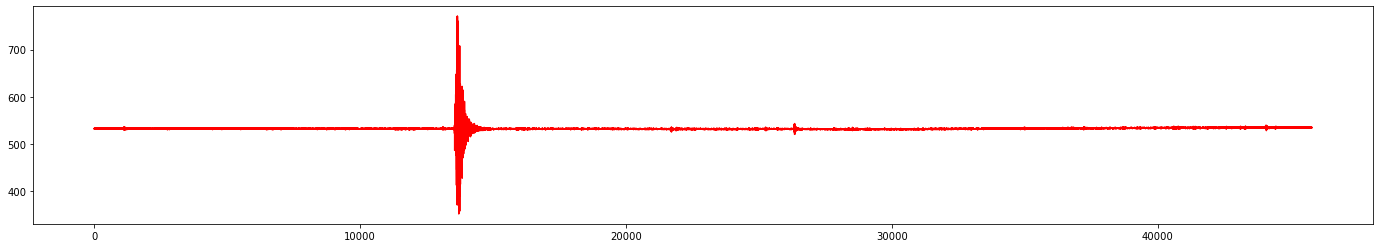

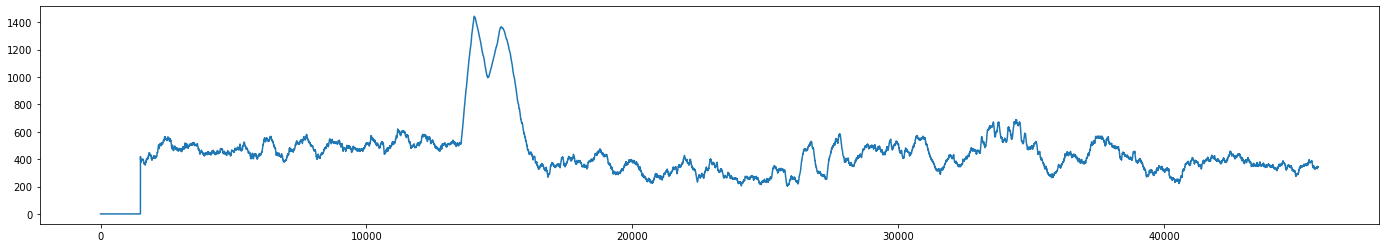

In [ ]:
cf = changefinder.ChangeFinder(r=0.5, order=1, smooth=1000)

ret = []
for i in smq.spz[0].data[::100]:
    score = cf.update(i)
    ret.append(score)

# 可視化
vis(smq.spz[0].data[::100],'r')
vis(ret)

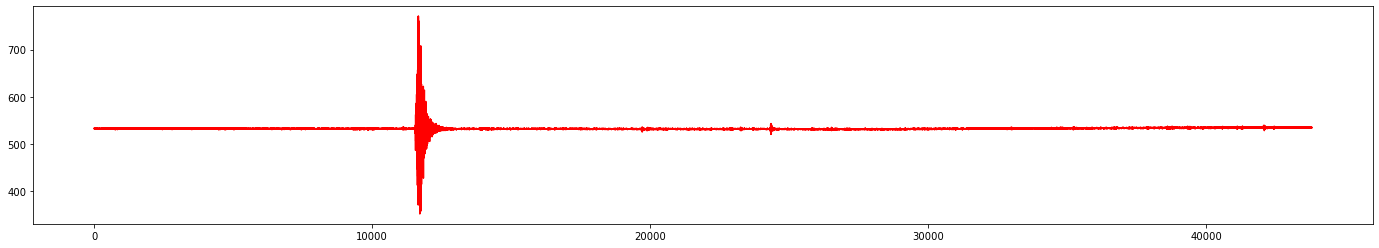

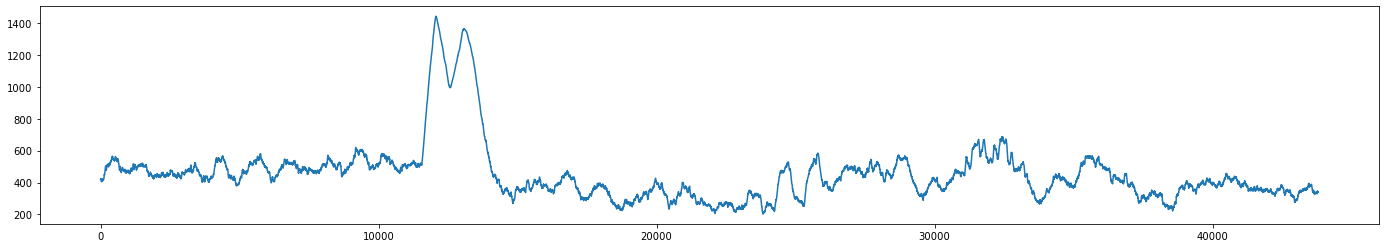

In [ ]:
vis(smq.spz[0].data[::100][2000:],'r')
vis(ret[2000:])

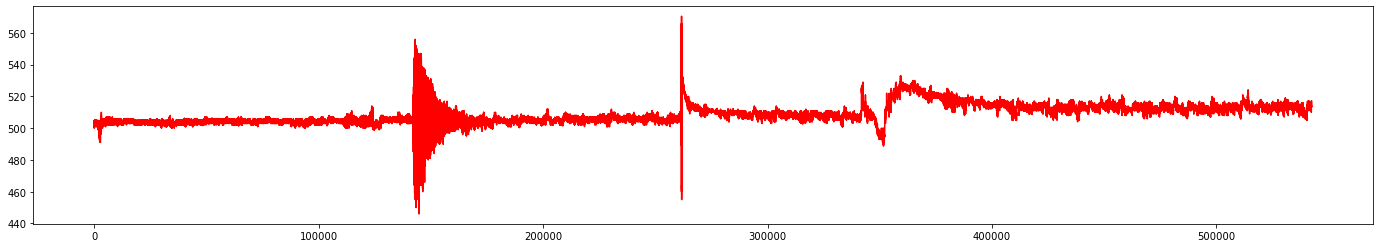

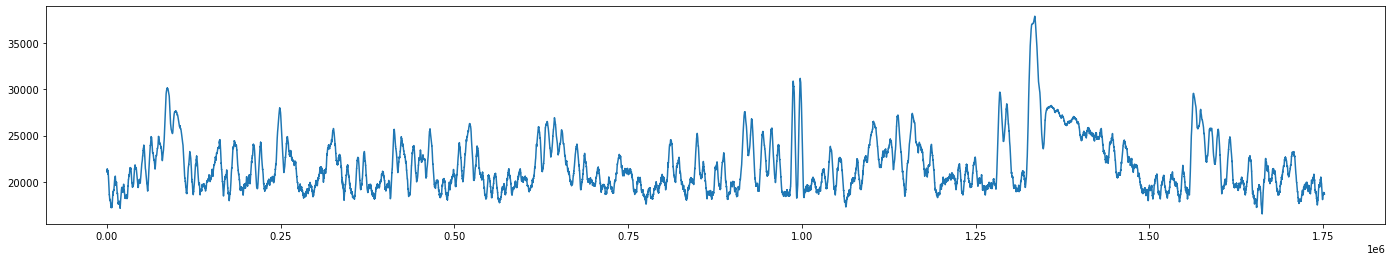

In [ ]:
# 可視化
vis(smq.spz[0].data[:],'r')
vis(ret[30000:])

# ノイズ除去 (EnvelopeとEWMの比較)

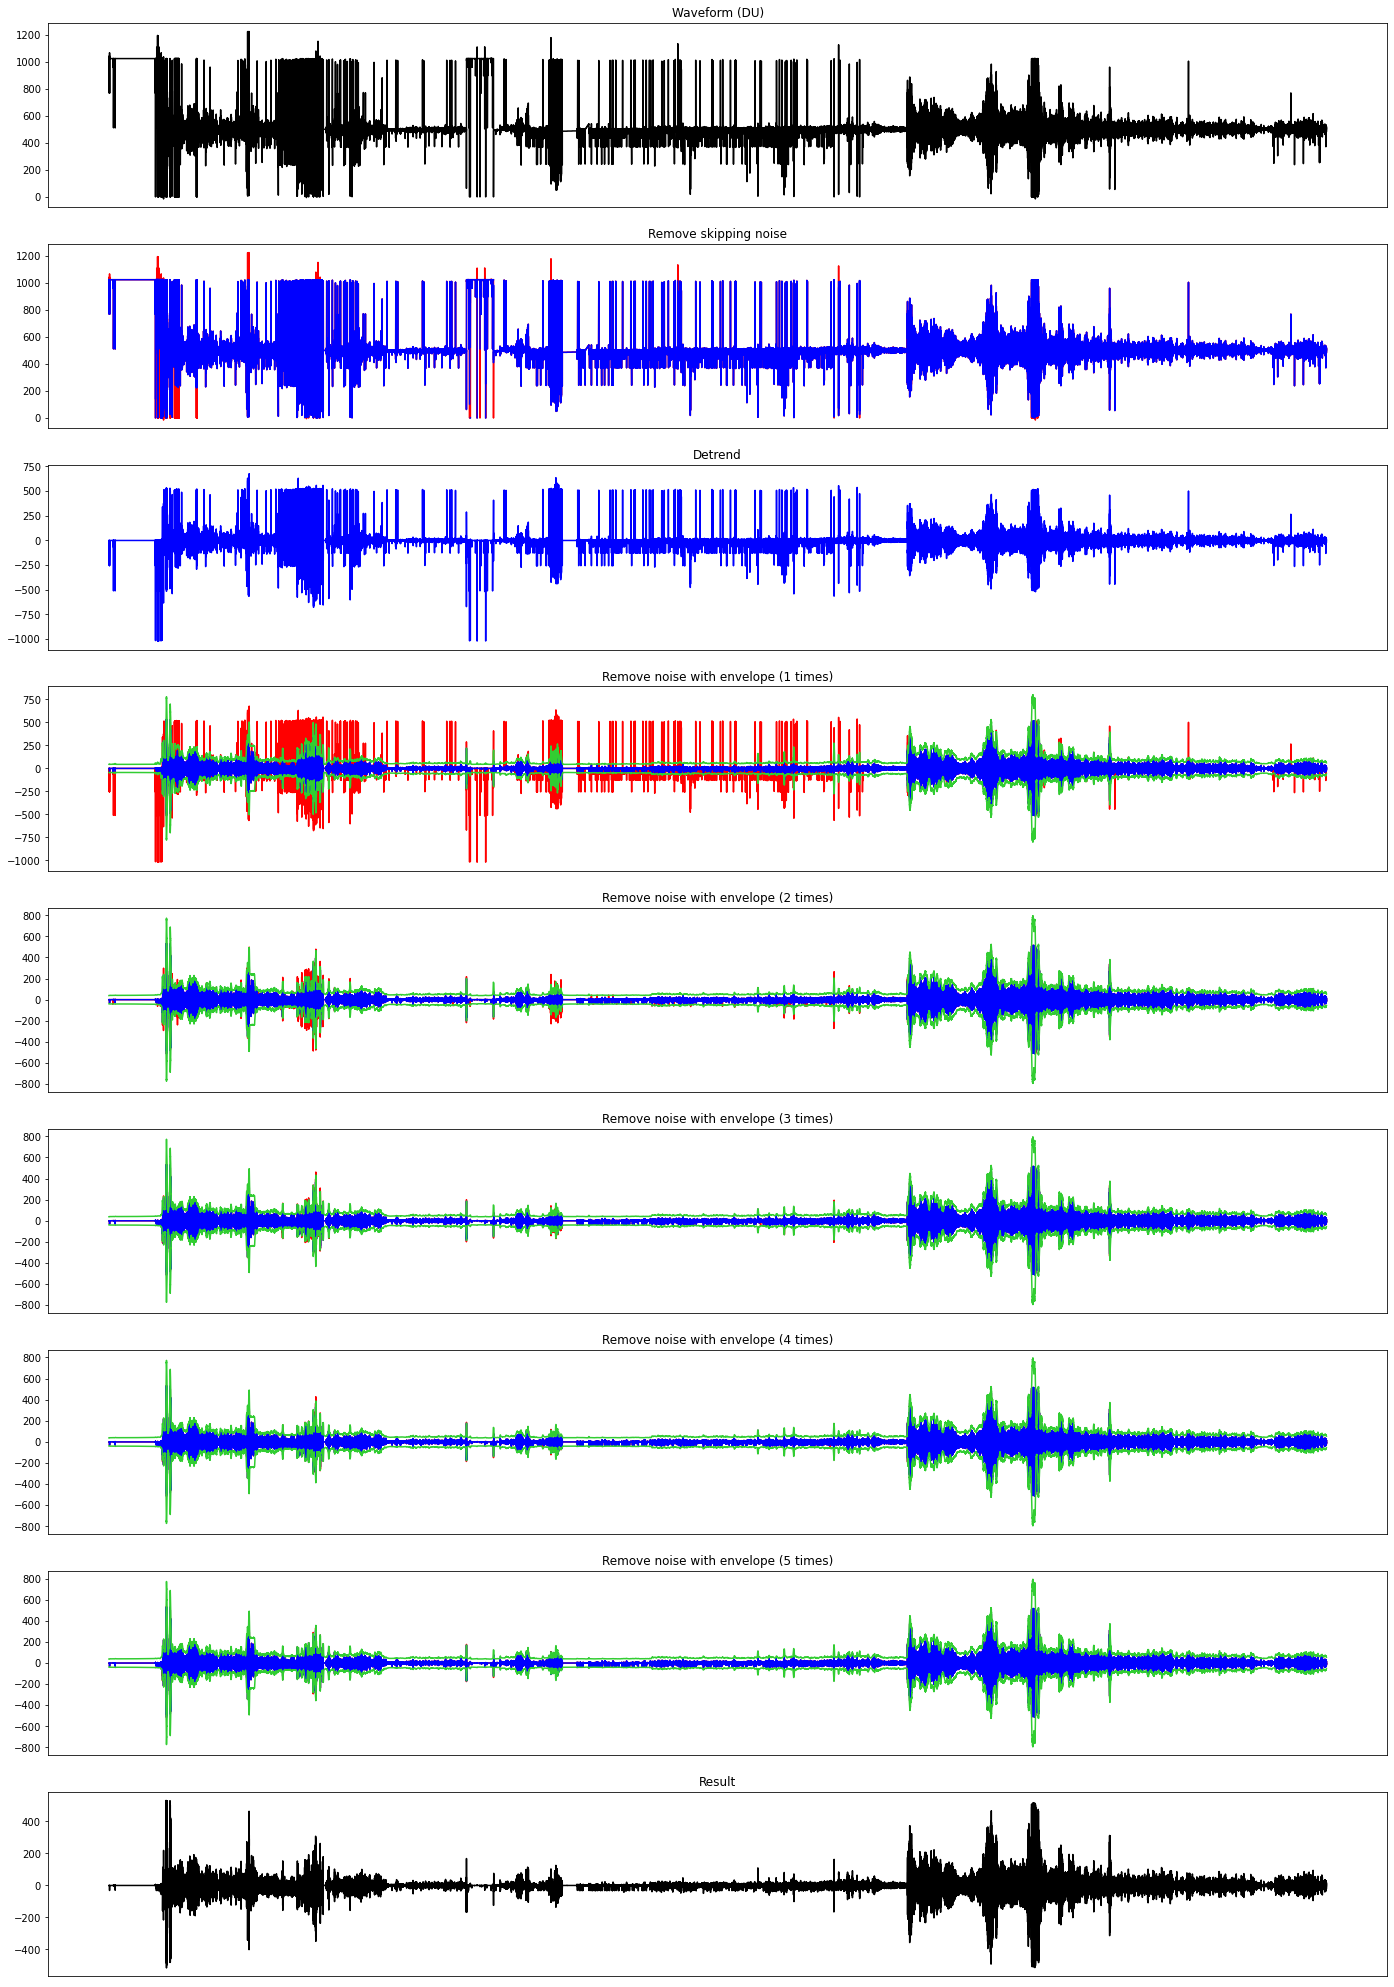

In [25]:
station_num = 14
path = './dataset/one_day/S14/pse.a14.01.001'

smq = MQ_Analysis(station_num)
smq.read_sac(path)
ch = 'SPZ'
smq.remove_noise(channel=ch, method='envelope', times=5, verbose=1)

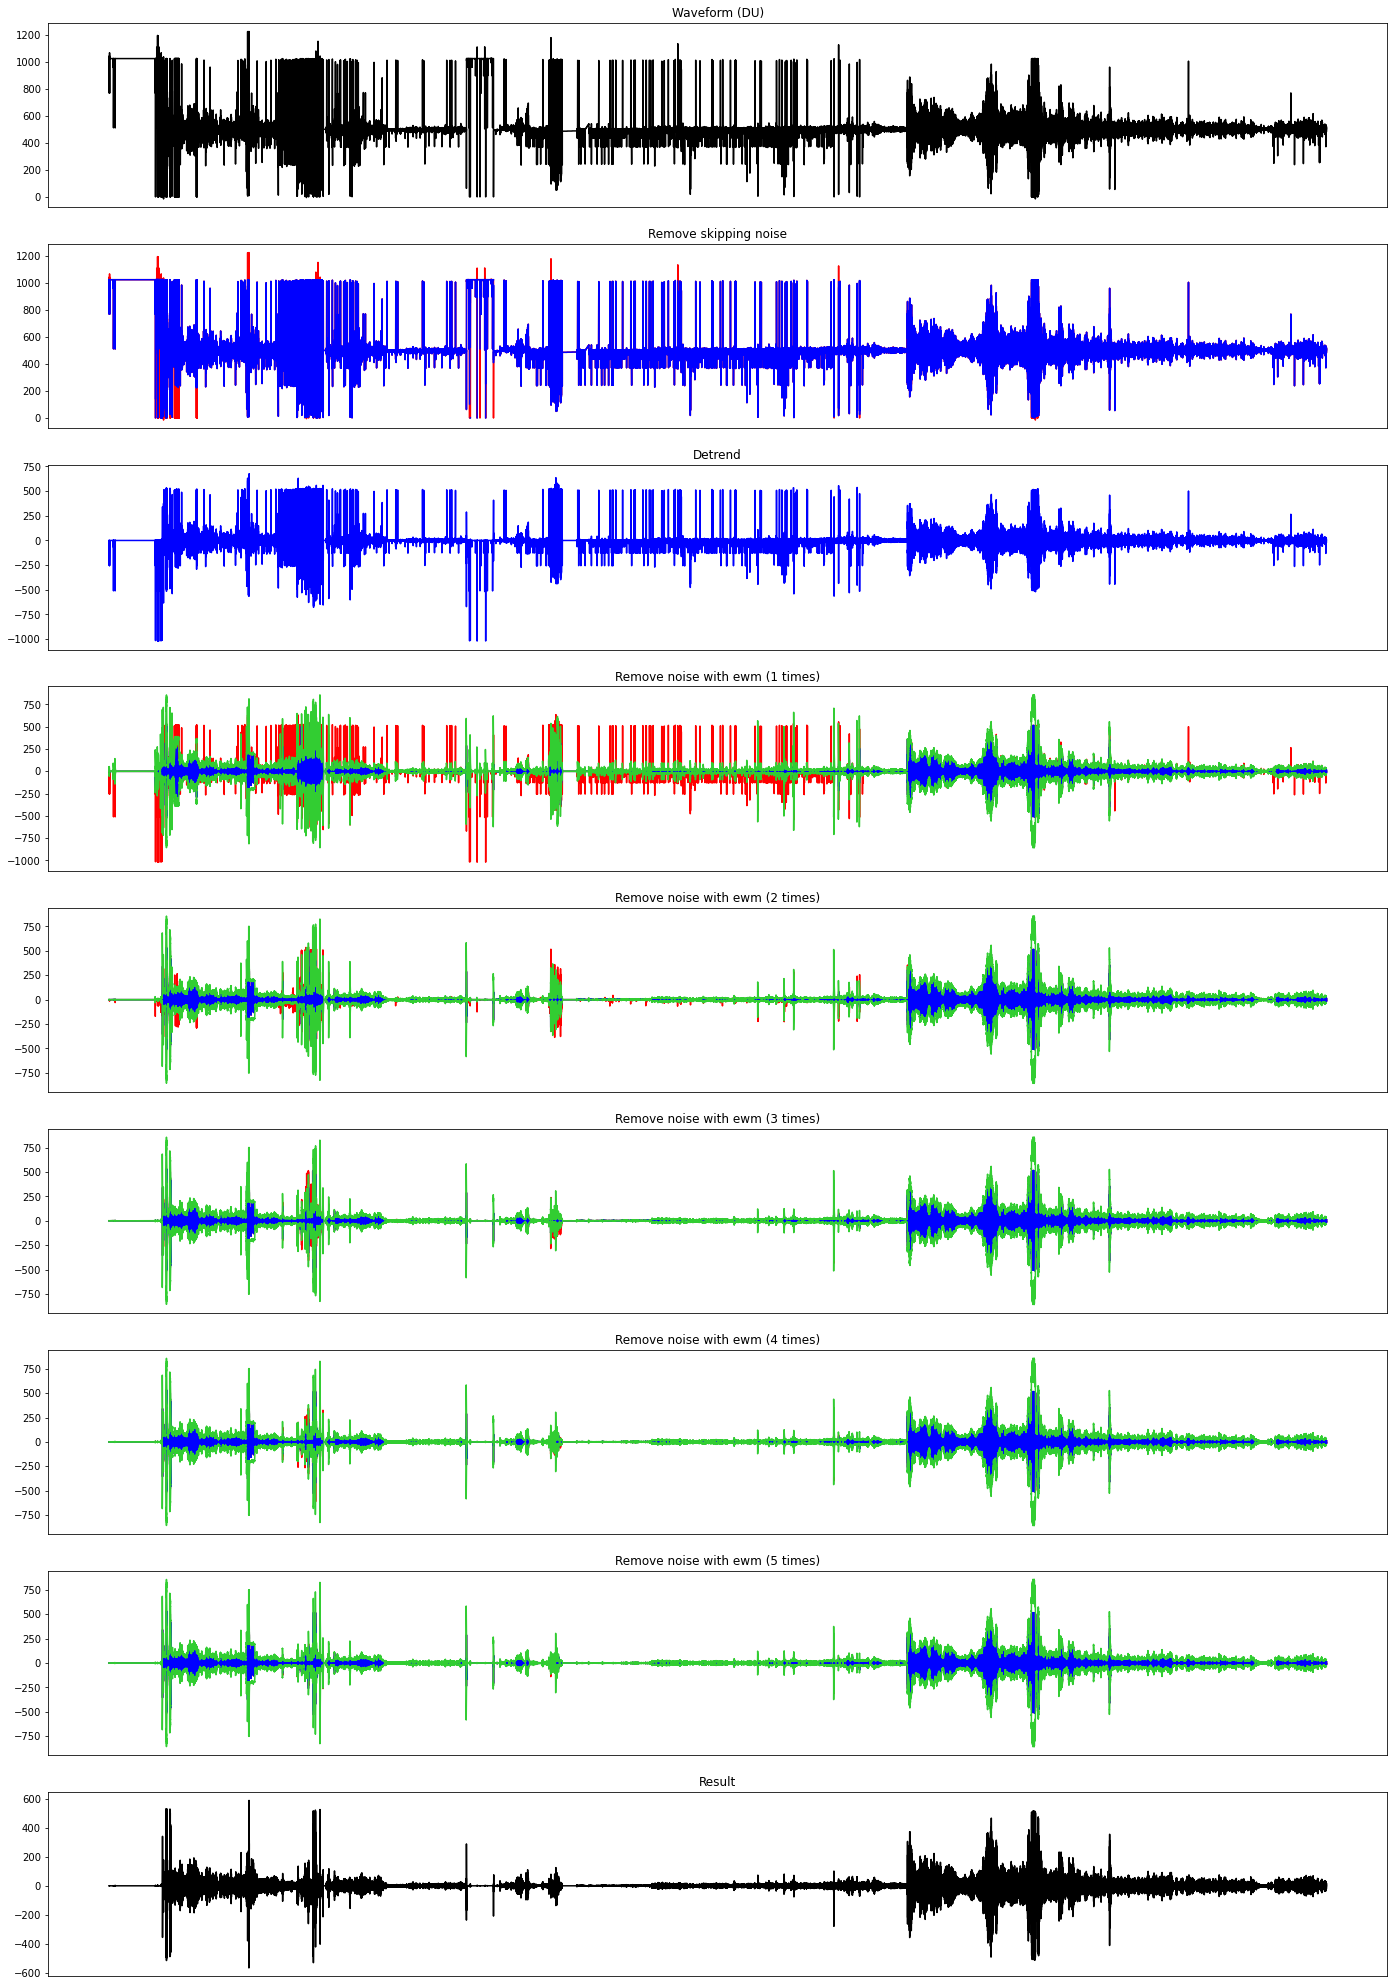

In [26]:
station_num = 14
path = './dataset/one_day/S14/pse.a14.01.001'

smq = MQ_Analysis(station_num)
smq.read_sac(path)
ch = 'SPZ'
smq.remove_noise(channel=ch, method='ewm', times=5, verbose=1)

# ノイズ除去 (ほぼ同じ期間で14号~16号の比較 (SMQあり))

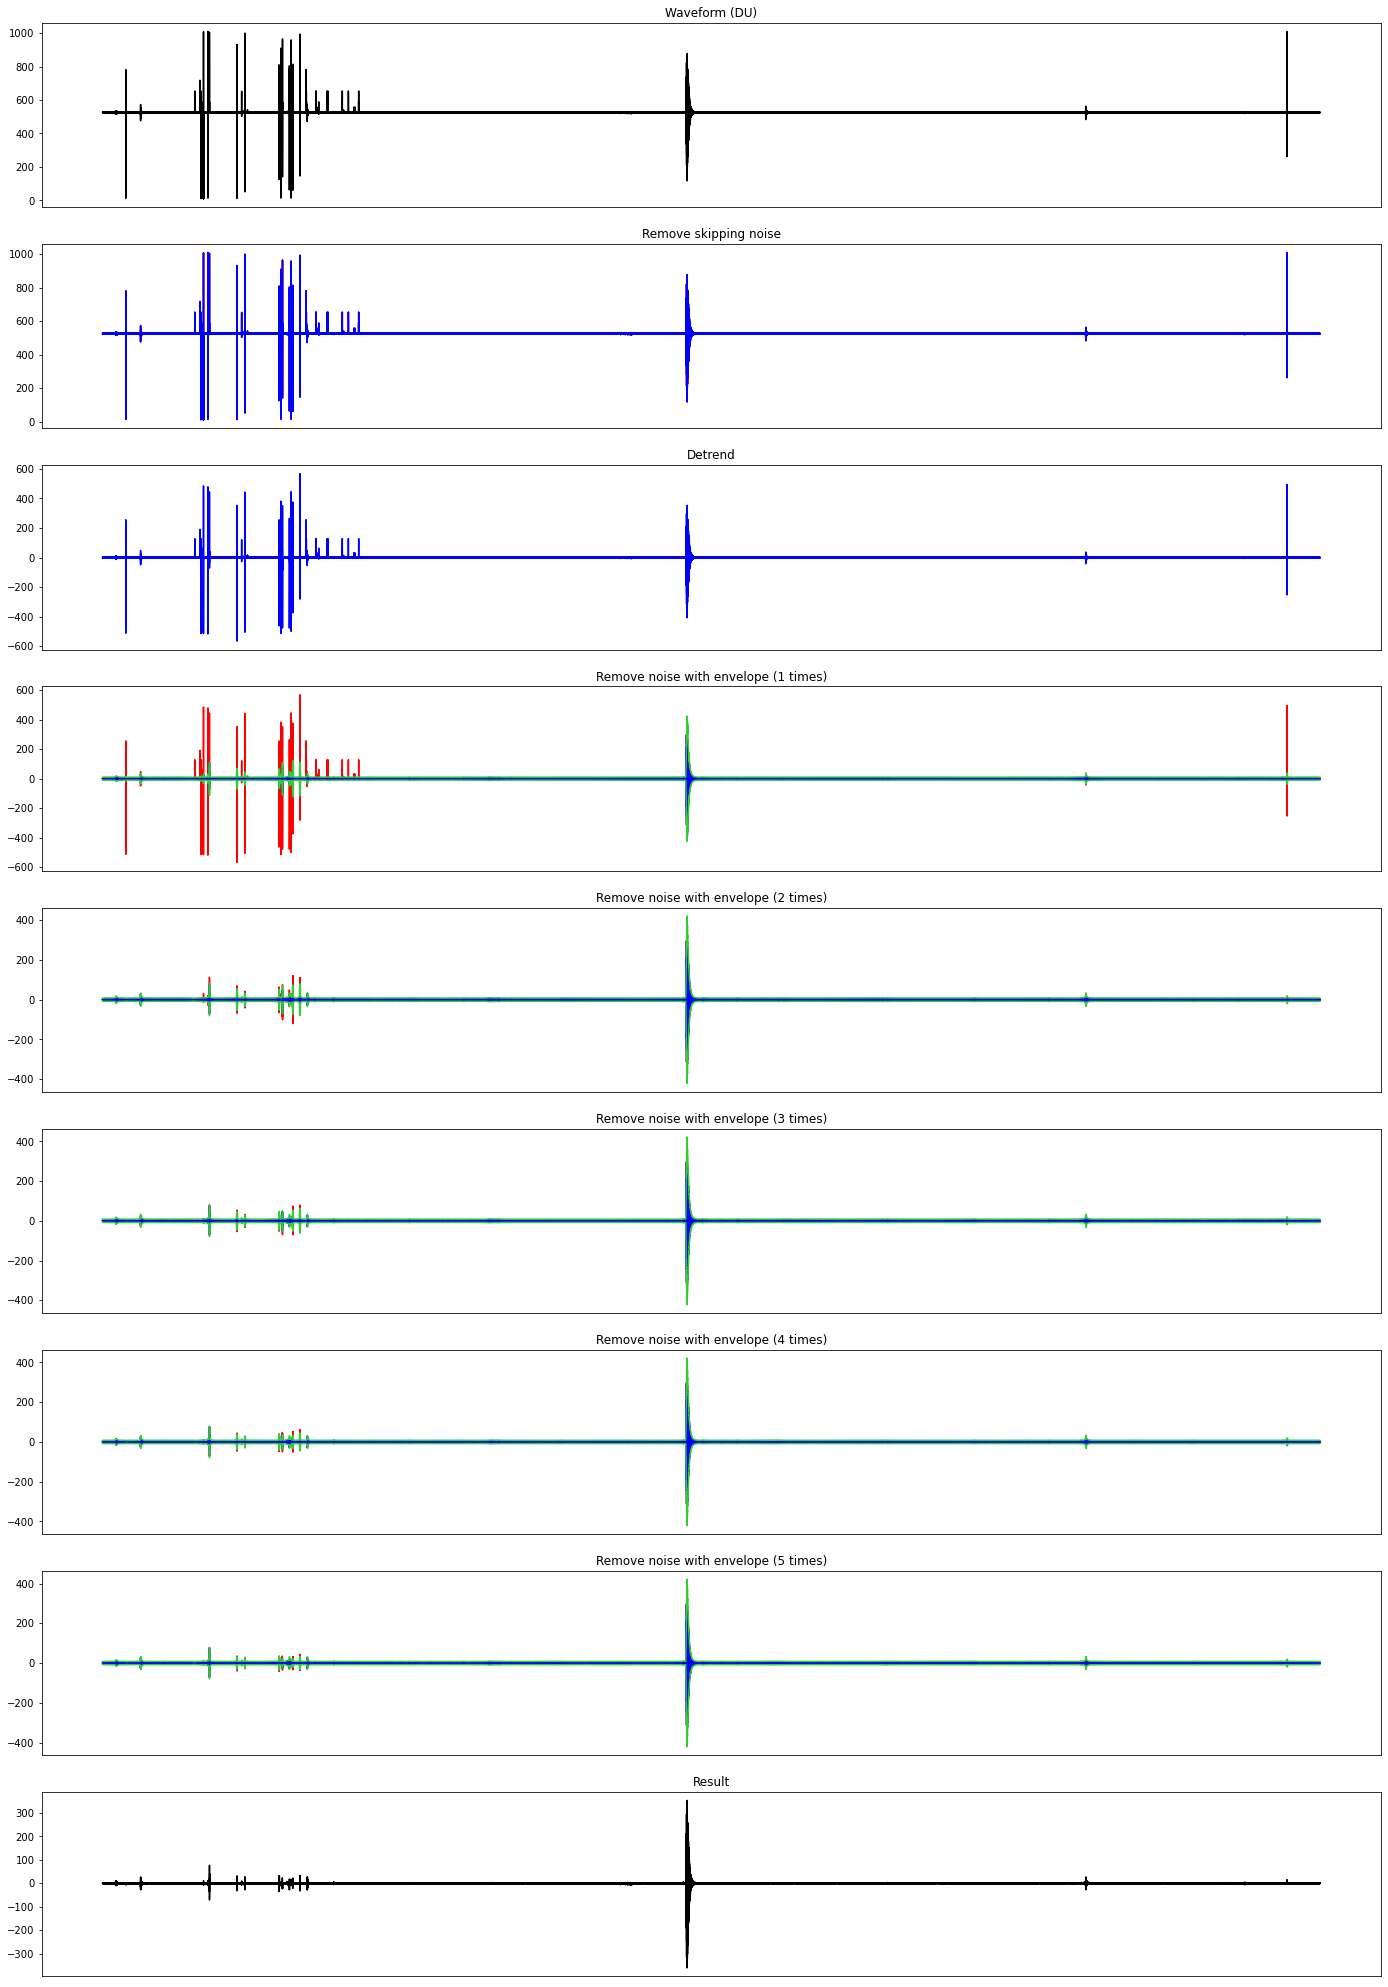

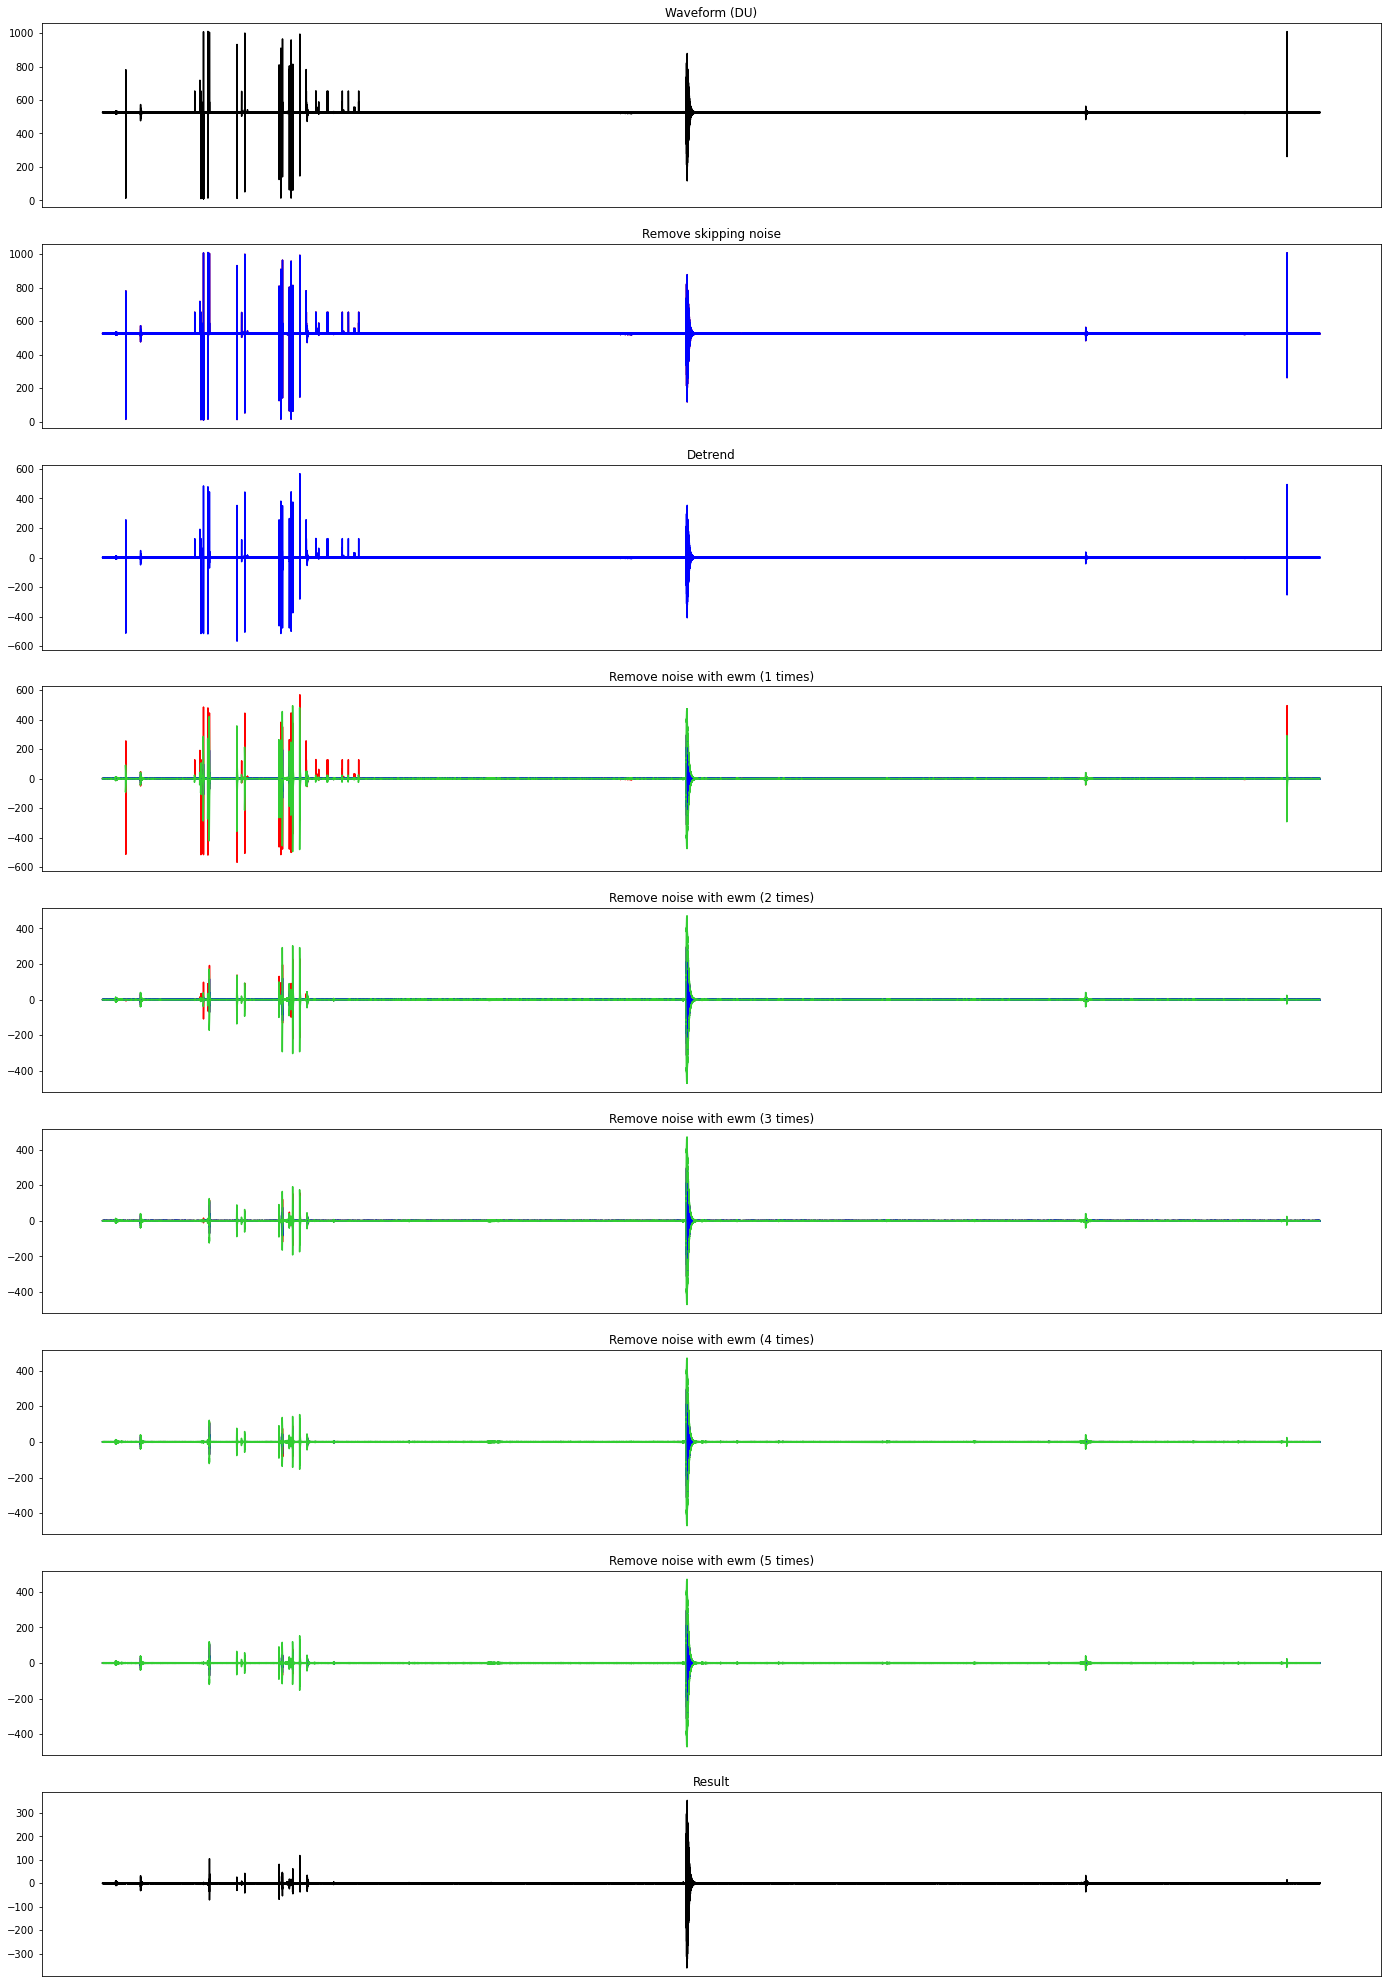

In [29]:
station_num = 14
# station_num = 15
# station_num = 16
# path = './dataset/SMQ_710417/S14'
# path = './dataset/SMQ_710520/S14'
# path = './dataset/SMQ_710711/S14'
# path = './dataset/SMQ_720102/S14'
# path = './dataset/SMQ_730208/S14'

# path = './dataset/SMQ_740223/S16'
# path = './dataset/one_day/S14/pse.a14.01.001'
path = './dataset/one_day/S14/pse.a14.07.055'
# path = './dataset/one_day/S14/pse.a14.07.056'
# path = './dataset/one_day/S15/pse.a15.06.055'
# path = './dataset/one_day/S15/pse.a15.06.056'
# path = './dataset/one_day/S16/pse.a16.04.148'
# path = './dataset/one_day/S16/pse.a16.04.149'

smq = MQ_Analysis(station_num)
smq.read_sac(path)
ch = 'SPZ'
smq.remove_noise(channel=ch, method='envelope', times=5, verbose=1)
smq.init_data()
smq.remove_noise(channel=ch, method='ewm', times=5, verbose=1)

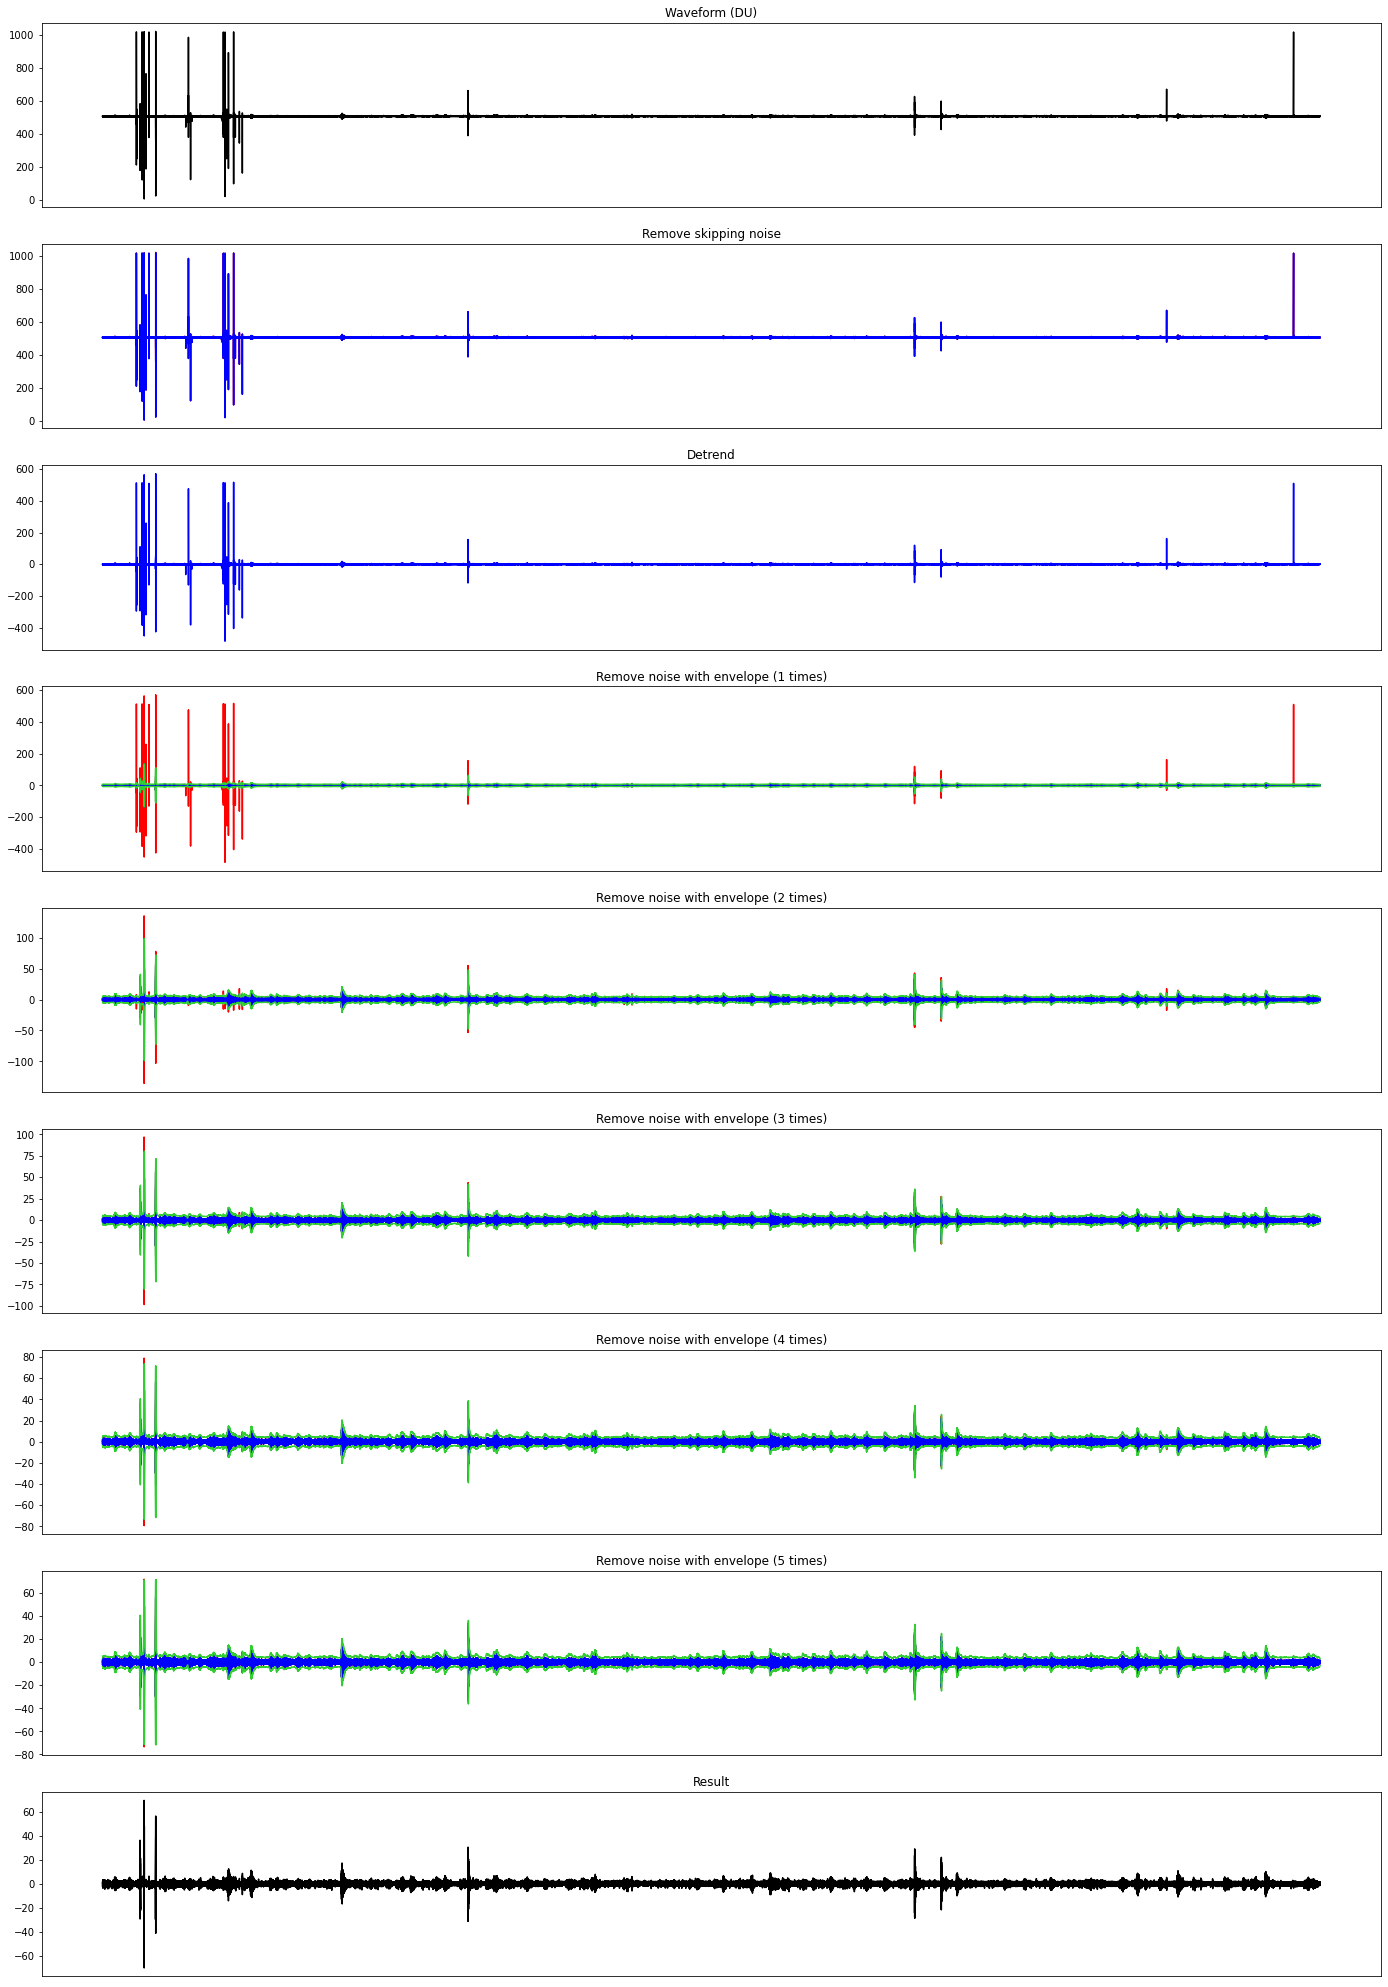

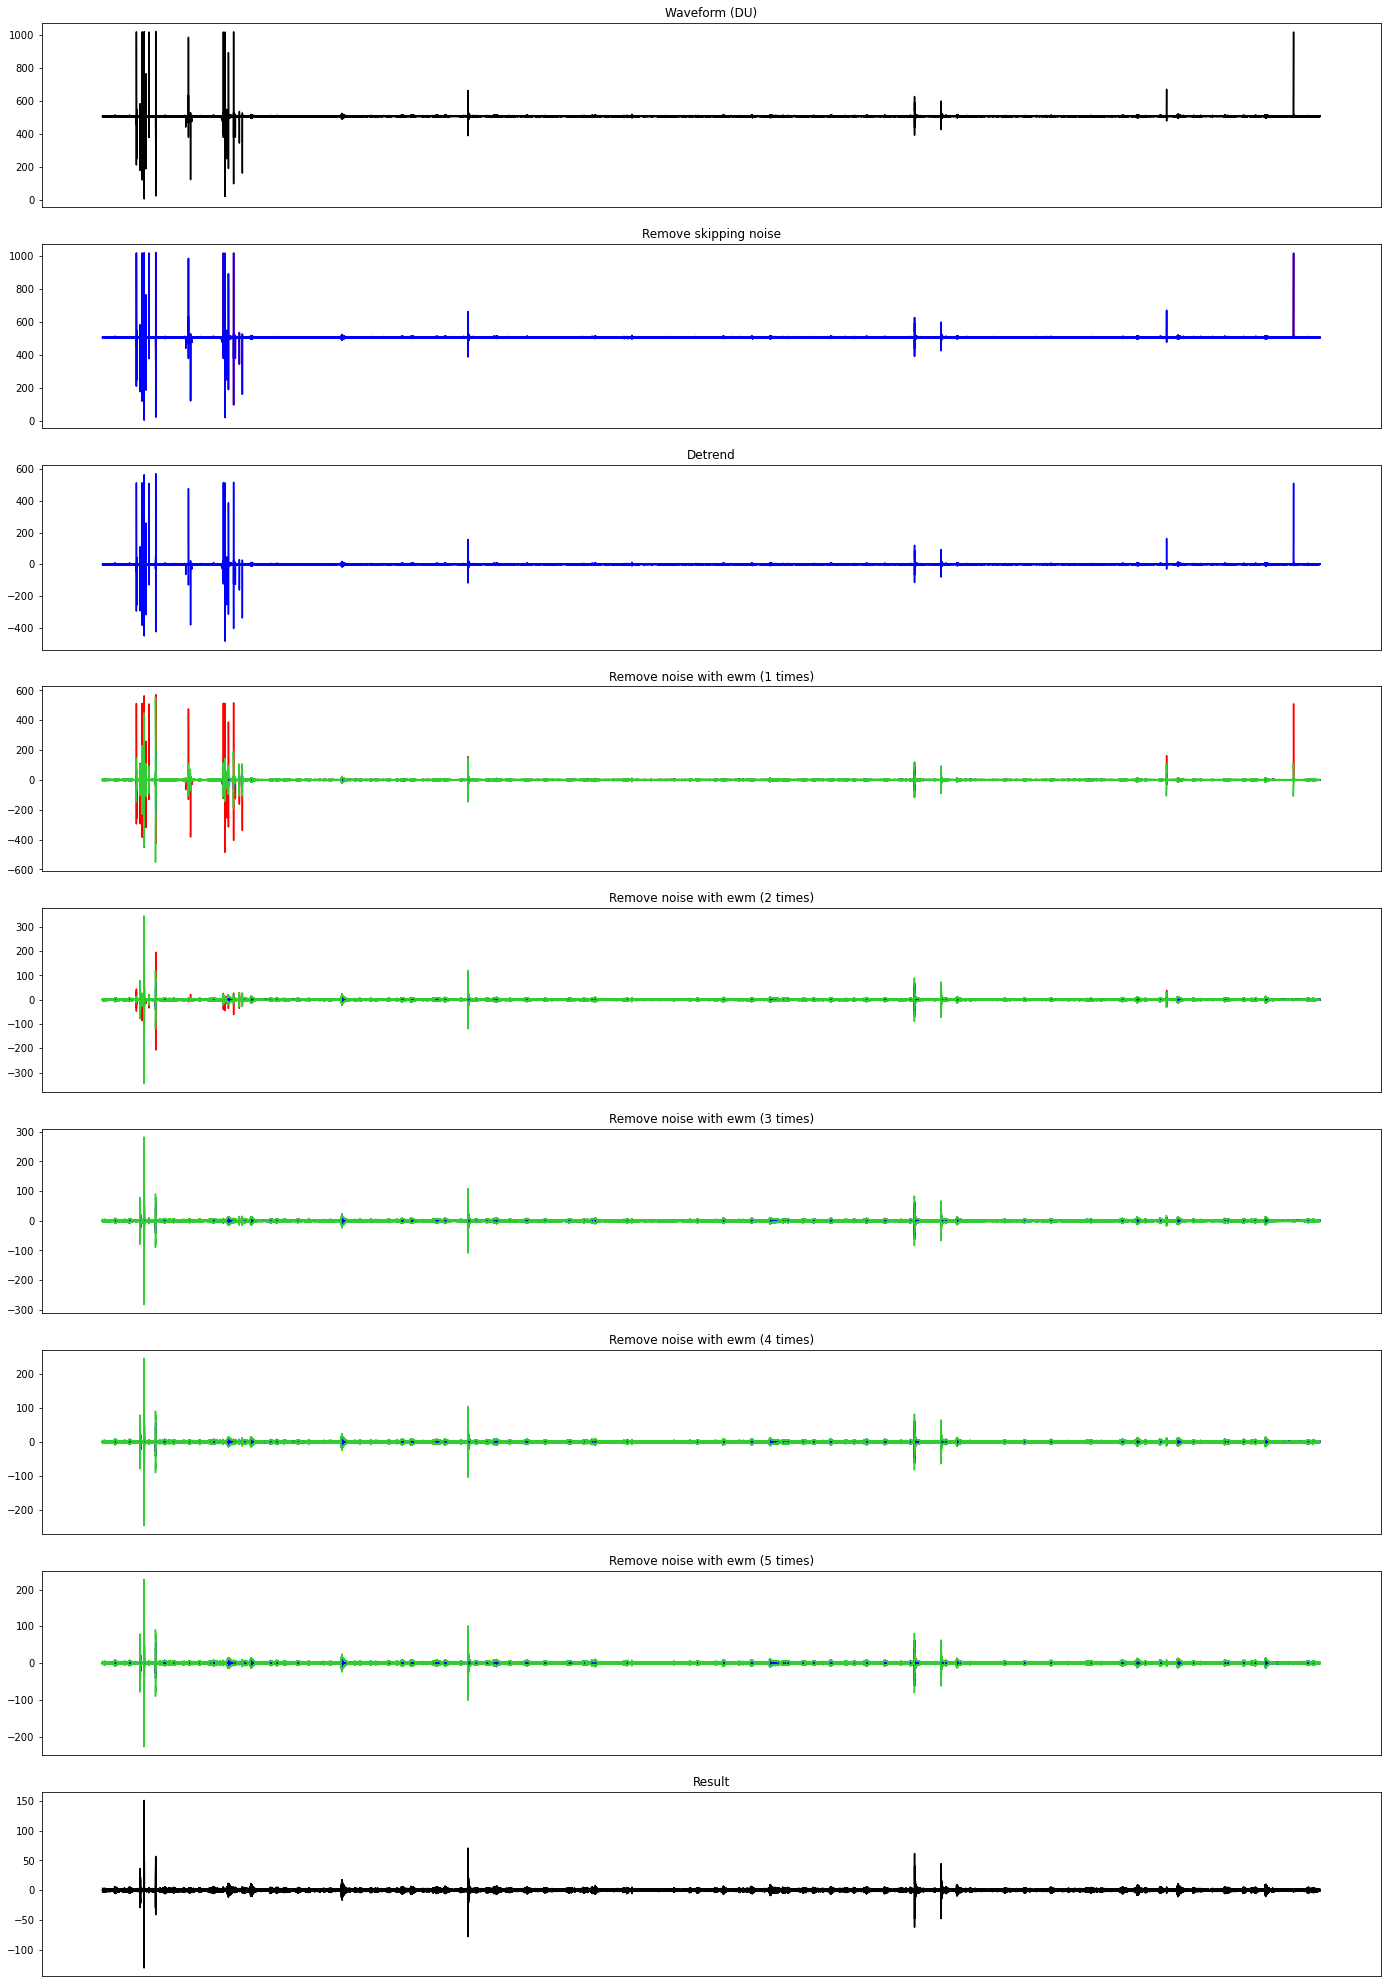

In [30]:
# station_num = 14
station_num = 15
# station_num = 16
# path = './dataset/SMQ_710417/S14'
# path = './dataset/SMQ_710520/S14'
# path = './dataset/SMQ_710711/S14'
# path = './dataset/SMQ_720102/S14'
# path = './dataset/SMQ_730208/S14'

# path = './dataset/SMQ_740223/S16'
# path = './dataset/one_day/S14/pse.a14.01.001'
# path = './dataset/one_day/S14/pse.a14.07.055'
# path = './dataset/one_day/S14/pse.a14.07.056'
path = './dataset/one_day/S15/pse.a15.06.055'
# path = './dataset/one_day/S15/pse.a15.06.056'
# path = './dataset/one_day/S16/pse.a16.04.148'
# path = './dataset/one_day/S16/pse.a16.04.149'

smq = MQ_Analysis(station_num)
smq.read_sac(path)
ch = 'SPZ'
smq.remove_noise(channel=ch, method='envelope', times=5, verbose=1)
smq.init_data()
smq.remove_noise(channel=ch, method='ewm', times=5, verbose=1)

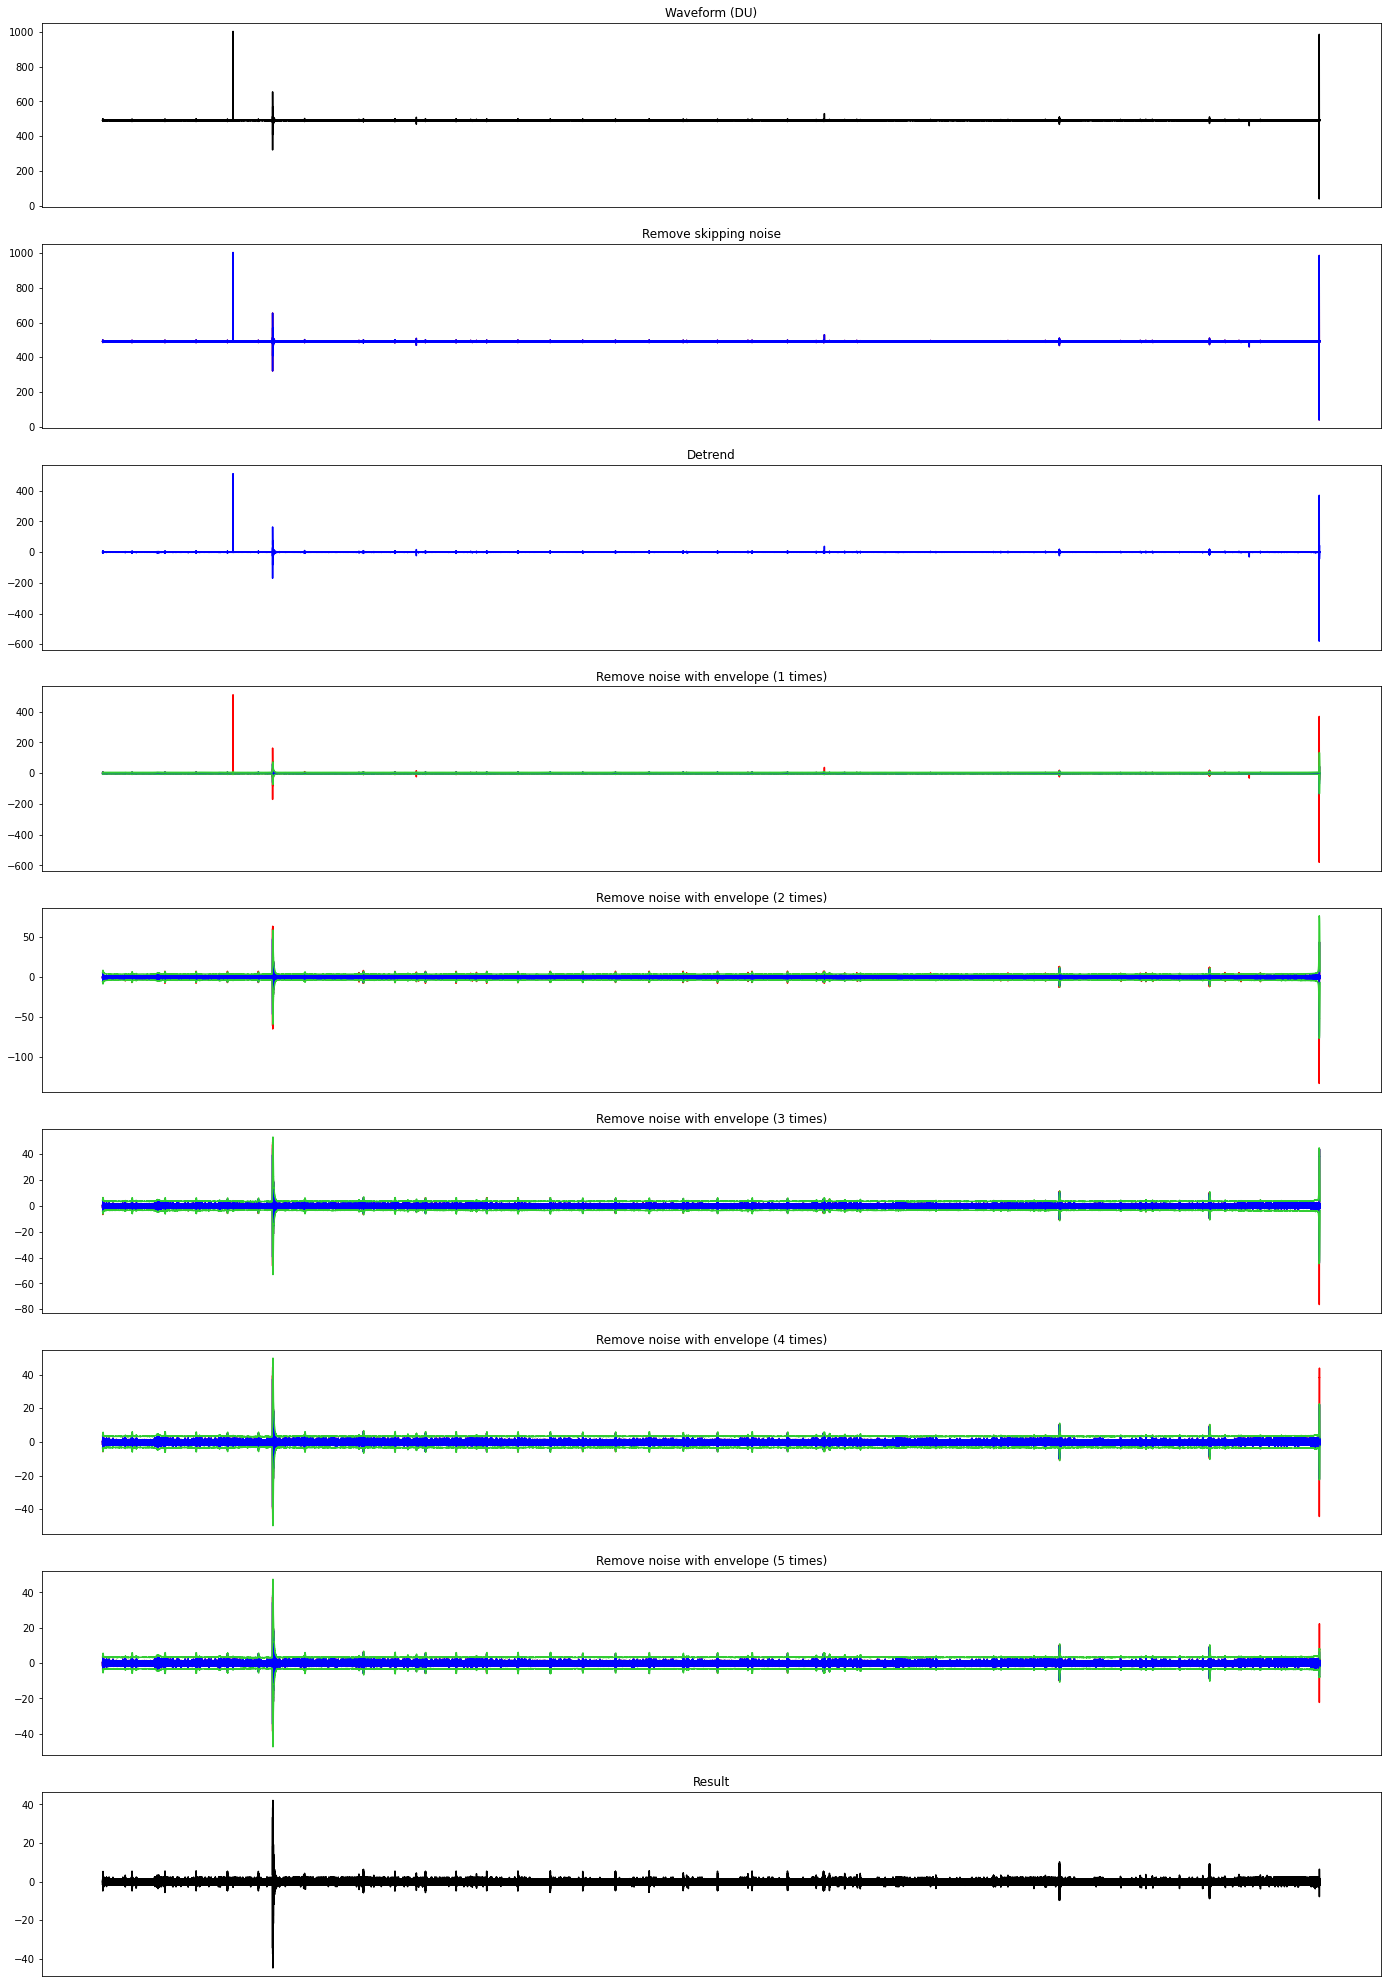

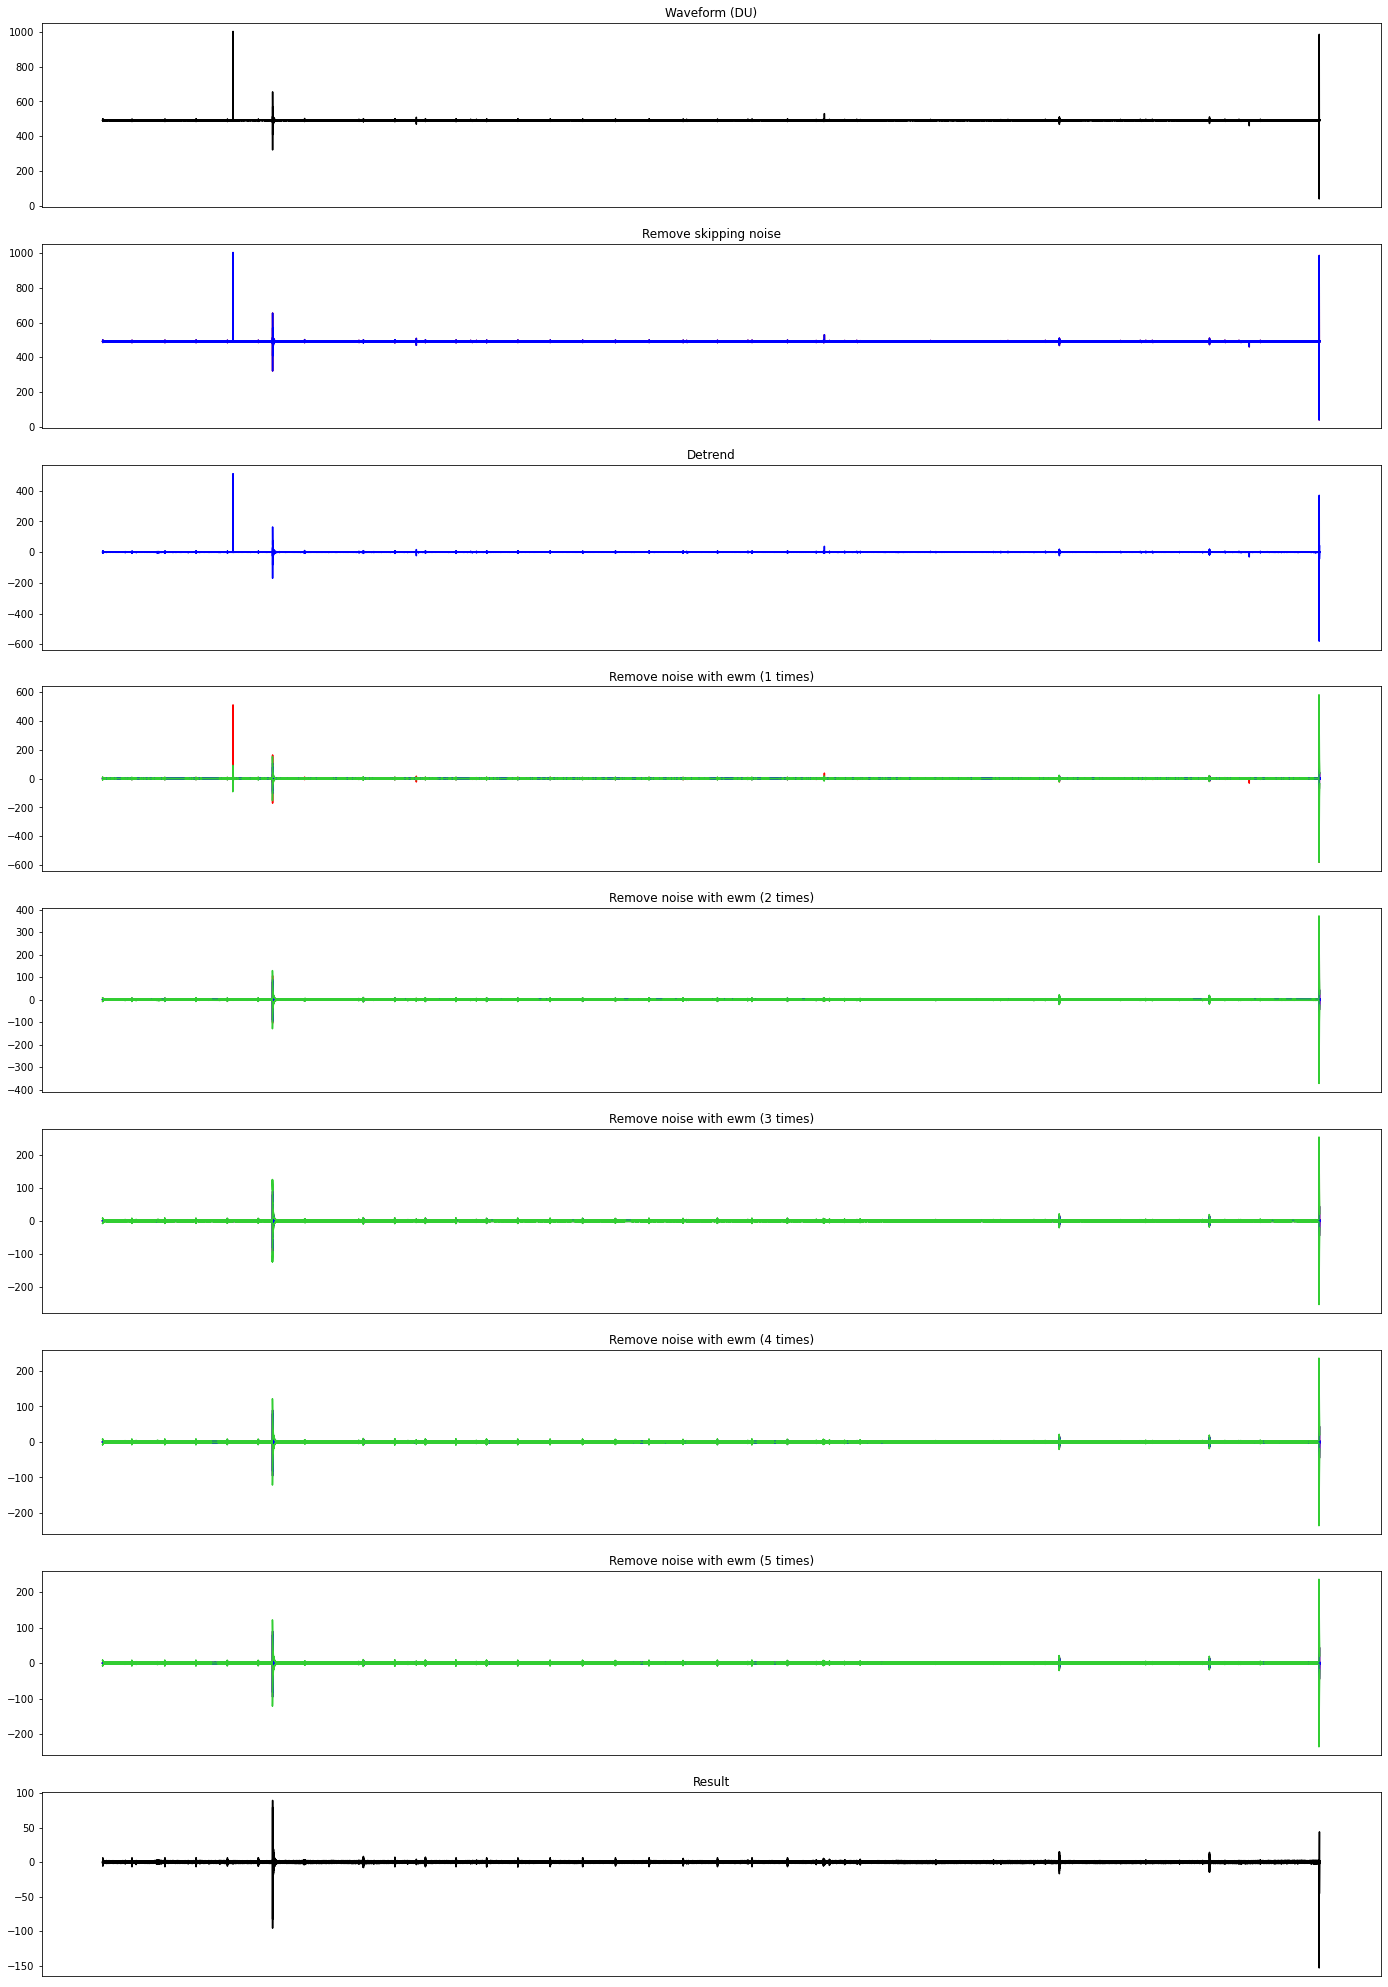

In [31]:
# station_num = 14
# station_num = 15
station_num = 16
# path = './dataset/SMQ_710417/S14'
# path = './dataset/SMQ_710520/S14'
# path = './dataset/SMQ_710711/S14'
# path = './dataset/SMQ_720102/S14'
# path = './dataset/SMQ_730208/S14'

# path = './dataset/SMQ_740223/S16'
# path = './dataset/one_day/S14/pse.a14.01.001'
# path = './dataset/one_day/S14/pse.a14.07.055'
# path = './dataset/one_day/S14/pse.a14.07.056'
# path = './dataset/one_day/S15/pse.a15.06.055'
# path = './dataset/one_day/S15/pse.a15.06.056'
path = './dataset/one_day/S16/pse.a16.04.148'
# path = './dataset/one_day/S16/pse.a16.04.149'

smq = MQ_Analysis(station_num)
smq.read_sac(path)
ch = 'SPZ'
smq.remove_noise(channel=ch, method='envelope', times=5, verbose=1)
smq.init_data()
smq.remove_noise(channel=ch, method='ewm', times=5, verbose=1)

# TEST

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

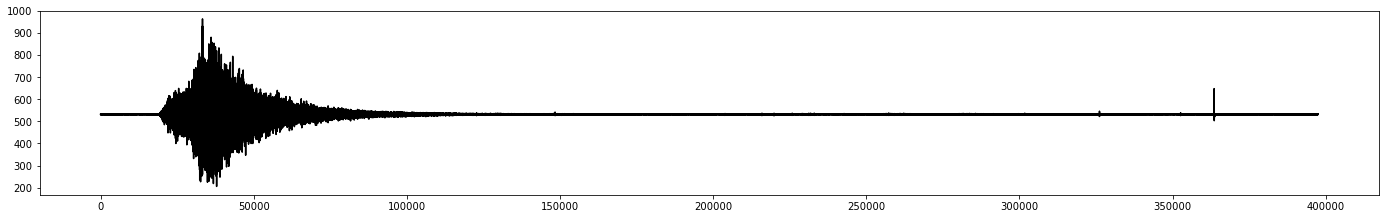

In [87]:
station_num = 14
# station_num = 15
# station_num = 16
path = './dataset/SMQ_710417/S14'
# path = './dataset/SMQ_710520/S14'
# path = './dataset/SMQ_710711/S14'
# path = './dataset/SMQ_720102/S14'
# path = './dataset/SMQ_730208/S14'

# path = './dataset/SMQ_740223/S16'
# path = './dataset/one_day/S14/pse.a14.01.001'
# path = './dataset/one_day/S14/pse.a14.07.055'
# path = './dataset/one_day/S14/pse.a14.07.056'
# path = './dataset/one_day/S15/pse.a15.06.055'
# path = './dataset/one_day/S15/pse.a15.06.056'
# path = './dataset/one_day/S16/pse.a16.04.148'
# path = './dataset/one_day/S16/pse.a16.04.149'

smq = MQ_Analysis(station_num)
smq.read_sac(path)
ch = 'SPZ'
smq.remove_noise(channel=ch, method='ewm', times=5, verbose=1)

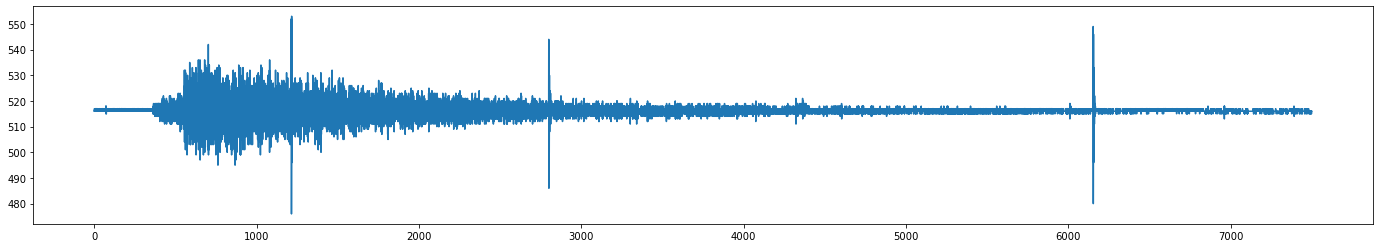

In [36]:
plt.plot(smq.lpz[0].times("utcdatetime"), smq.lpz[0].data)

([<matplotlib.axis.XTick at 0x7fd28123ca90>,
 [Text(0, 0, '1971-04-17T06:58:59.970283Z'),
  Text(12422, 0, '1971-04-17T07:30:14.989151Z'),
  Text(24844, 0, '1971-04-17T08:01:30.008019Z'),
  Text(37266, 0, '1971-04-17T08:32:45.026887Z'),
  Text(49687, 0, '1971-04-17T09:03:59.894811Z')])

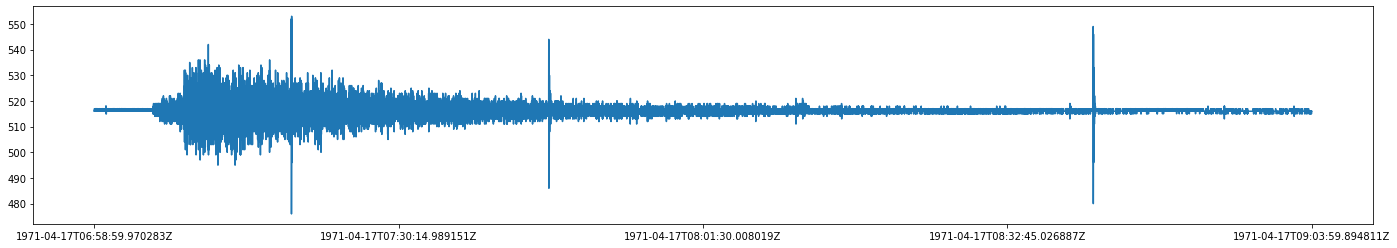

In [68]:
t = np.array(list(map(str, smq.lpz[0].times("utcdatetime"))))
n = len(t)
plt.plot(smq.lpz[0].data)
plt.xticks([0, 1*n//4, 2*n//4, 3*n//4, n-1], t[[0, 1*n//4, 2*n//4, 3*n//4, n-1]])